In [69]:
import jax
import jax.numpy as jnp
from tensorflow_probability.substrates import jax as tfp
import numpy as np
import flax.linen as nn
from typing import Any, List
import dataclasses
import distrax

Array = Any

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
tfd = tfp.distributions
tfb = tfp.bijectors

In [71]:
import sys
sys.path.append("../")

from models.maf import MaskedAutoregressiveFlow
from models.nsf import NeuralSplineFlow

## Test flow

In [72]:
import optax
import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage import rotate

In [73]:
image = Image.open('../data/iaifi-logo-black-noborder-hires.jpeg').convert('L')
data = np.asarray(image)

In [74]:
dist_true = ~data[::-1]
dist_true = dist_true / np.sum(dist_true)

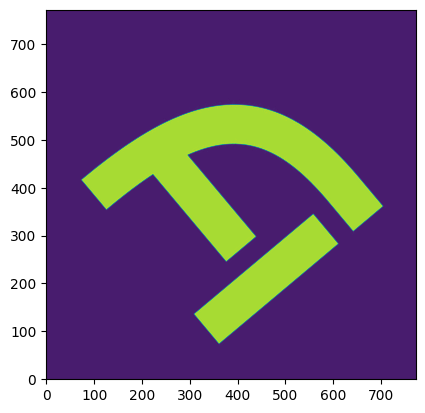

In [75]:
plt.imshow(rotate(dist_true, 50), origin='lower')

In [76]:
pairs = np.indices(dimensions=dist_true.shape).T

n = 5000
inds=np.random.choice(np.arange(np.prod(dist_true.shape)),p=dist_true.reshape(-1),size=n,replace=True)

selections = pairs.reshape(-1,2)[inds].astype(np.float32)
selections_std = selections.std()
selections_mean = selections.mean()


In [77]:
selections = (selections - selections_mean) / selections_std

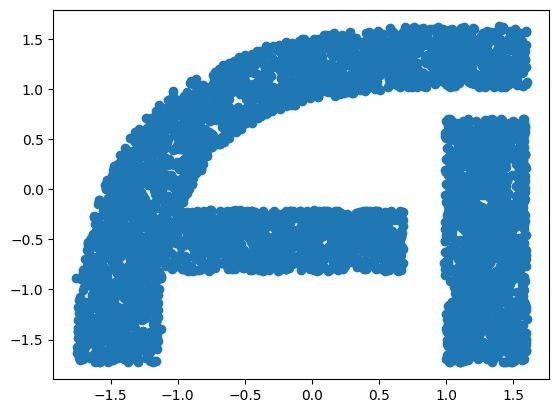

In [78]:
plt.scatter(*selections.T)


In [133]:
def rotate_points(points, angle):
    """Rotate points by angle around origin.
    """
    angle = jnp.deg2rad(angle)
    rot_matrix = jnp.array([[jnp.cos(angle), -jnp.sin(angle)], [jnp.sin(angle), jnp.cos(angle)]])
    return jnp.dot(points, rot_matrix)

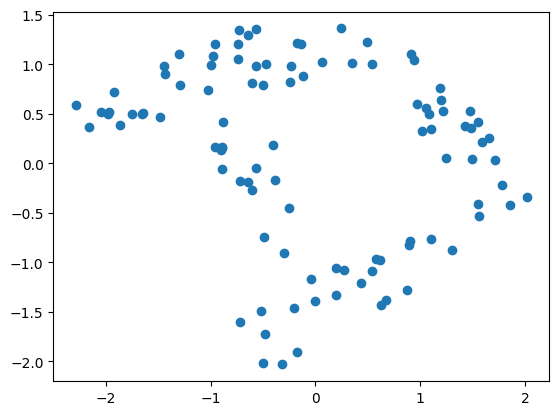

In [137]:
plt.scatter(*jax.vmap(rotate_points)(selections[None, :100], jnp.array([60.])).T)

In [172]:
n_dim = 2
# model = MaskedAutoregressiveFlow(n_dim=n_dim, n_context=1, hidden_dims=[128,128], n_transforms=8, activation="relu", use_random_permutations=False)
model = NeuralSplineFlow(n_dim=n_dim, n_context=1, hidden_dims=[128,128], n_transforms=8, activation="relu", n_bins=4)

key = jax.random.PRNGKey(42)
x = jax.random.uniform(key=key, shape=(8, n_dim))
z = jax.random.uniform(key=key, shape=(8, 1))
params = model.init(key, x, z)

In [173]:
model.apply(params, jnp.array(selections), jnp.ones((selections.shape[0], 1)));

In [174]:
optimizer = optax.adamw(learning_rate=3e-4, weight_decay=1e-5)
opt_state = optimizer.init(params)

@jax.jit
def loss_fn(params, x, z):
  loss = -jnp.mean(model.apply(params, x, z))
  return loss

@jax.jit
def update(params, opt_state, batch):
  x, z = batch
  grads = jax.grad(loss_fn)(params, x, z)
  updates, new_opt_state = optimizer.update(grads, opt_state, params)
  new_params = optax.apply_updates(params, updates)
  return new_params, new_opt_state


In [175]:
from tqdm import tqdm

batch_size = 64
n_steps = 10000

for step in tqdm(range(n_steps)):
    x = selections[np.random.choice(np.arange(len(selections)), size=batch_size, replace=False)]
    rot = np.random.uniform(low=0., high=np.pi, size=batch_size)
    x = jax.vmap(rotate_points)(x, np.rad2deg(rot))
    z = jnp.array(rot)[:, None]
    batch = x , z
    params, opt_state = update(params, opt_state, batch)


100%|██████████| 10000/10000 [01:09<00:00, 144.67it/s]


(-3.0, 3.0)

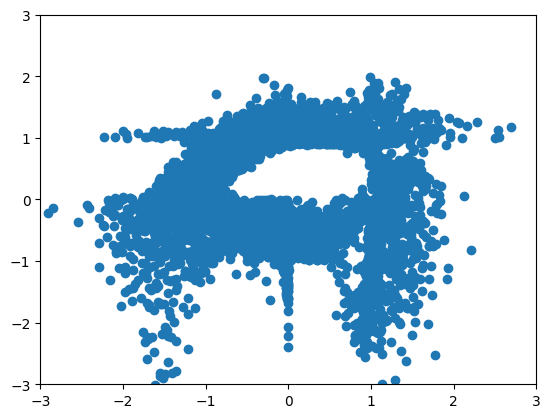

In [177]:
def eval_model(model):
    samples = model.sample(num_samples=5000, rng=jax.random.PRNGKey(54), context=np.deg2rad(0.) * jnp.ones((5000, 1)))
    return samples

samples = nn.apply(eval_model, model)(params)
plt.scatter(*samples.T)
plt.xlim(-3, 3)
plt.ylim(-3, 3)